In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import re
from os import listdir
from os.path import isfile, join
from random import shuffle
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pkg_resources
import time
import nltk

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from symspellpy import SymSpell 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import importlib
import utils 
from utils import *
import preprocessing
from preprocessing import *

importlib.reload(utils)
importlib.reload(preprocessing)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data.

<module 'preprocessing' from 'c:\\Users\\rayji\\OneDrive\\Documents\\GitHub\\ml-project-2-big-three\\preprocessing.py'>

In [4]:
# nltk weights
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Path

In [5]:
# Global path
GLOBAL_PATH = "C:/Users/rayji/OneDrive/Documents/Projet 2 ML"

# GloVe
GLOVE_PATH = f"{GLOBAL_PATH}/data/glove.twitter.27B.100d.txt"

# Train full
TRAIN_NEG_FULL_PATH = f"{GLOBAL_PATH}/data/train_neg_full.txt"
TRAIN_POS_FULL_PATH = f"{GLOBAL_PATH}/data/train_pos_full.txt"

# Train
TRAIN_NEG_PATH = f"{GLOBAL_PATH}/data/train_neg.txt"
TRAIN_POS_PATH = f"{GLOBAL_PATH}/data/train_pos.txt"

# Test
TEST_PATH = f"{GLOBAL_PATH}/data/test_data.txt"

# Preprocessed data
TRAIN_PREP_PATH = f"{GLOBAL_PATH}/data/preprocessed/train_gru.csv"
TEST_PREP_PATH = f"{GLOBAL_PATH}/data/preprocessed/test_gru.csv"

# Weight
WEIGHT_PATH = f"{GLOBAL_PATH}/weight"

\<user\>
\<url\>

Positive Smileys : <3 :p :') :d [: >:d < ^ - ^
Negative smileys : xd

"(" or ")" maybe come from ":((" or ":))" that became  "(" or ")" after removing ":(" or ":)"
Still need to check if "(" is followed by a ")" or not

Abbreviations : fr = for real

Maybe can try to use a tokenizer specific to Twitter


Some tweets are duplicated, x2, x3, x5 ...



In [6]:
!pip install symspellpy

# Loading DataSet

In [7]:
data_train = load_data()

In [8]:
data_train

,text,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
199995,can't wait to fake tan tonight ! hate being pale,0
199996,<user> darling i lost my internet connection ....,0
199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0
199998,rizan is sad now,0


In [9]:
def run_preprocessing(method_list, full_data=True):
    """
    Runs the preprocessing methods according to the chosen classifier
      on the train and test data

    :param csr: chosen classifier (child of AbstractModel)
    :type csr: AbstractModel
    :param train_preprocessed_path: path to load train data
    :type train_preprocessed_path: str
    :param test_preprocessed_path: path to load test data
    :type test_preprocessed_path: str
    :param full_data: if False, the small dataset (200K rows) is used
    :type full_data: bool, optional
    """

    # Read data
    if full_data:
        dataset_files = [TRAIN_NEG_FULL_PATH, TRAIN_POS_FULL_PATH]
    else:
        dataset_files = [TRAIN_NEG_PATH, TRAIN_POS_PATH]

    train_preprocessing = Preprocessing(dataset_files, is_test=False)
    test_preprocessing = Preprocessing([TEST_PATH], is_test=True)

    # Preprocess it

    methods = method_list
    
    for method in methods:
        getattr(test_preprocessing, method)()

    methods.append('drop_duplicates')


    for method in methods:
        getattr(train_preprocessing, method)()

    train_df = train_preprocessing.__get__()
    #train_df.to_csv(train_preprocessed_path, index=False)

    test_df = test_preprocessing.__get__()
    #test_df.to_csv(test_preprocessed_path, index=False)

    return train_df, test_df

# Model initialisation

Initializing a model to test the accuracy of the different preprocessing steps

In [10]:
def test_dataset(dataset):    
# Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=42)

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Transform the text data into TF-IDF features
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train a logistic regression model
    model = LogisticRegression(max_iter=100000)
    model.fit(X_train_tfidf, y_train)

    # Predict labels for the test set
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    return accuracy

In [11]:
methods = []

dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `drop_duplicates`
Accuracy: 0.796315702388175
Computation Time: 6.653909683227539


# Characters

In [12]:
# Create a Counter object for positive labels
positive_counter = Counter(''.join(data_train[data_train['label'] == 1]['text']))

# Create a Counter object for negative labels
negative_counter = Counter(''.join(data_train[data_train['label'] == 0]['text']))

# Create a DataFrame from the positive Counter
positive_df = pd.DataFrame.from_dict(positive_counter, orient='index').reset_index()
positive_df.columns = ['Character', 'Count']
positive_df.sort_values('Character', ascending=False, inplace=True)

# Create a DataFrame from the negative Counter
negative_df = pd.DataFrame.from_dict(negative_counter, orient='index').reset_index()
negative_df.columns = ['Character', 'Count']
negative_df.sort_values('Character', ascending=False, inplace=True)

# Remove spaces and letters
positive_df = positive_df[~positive_df['Character'].isin(list(' '))]
negative_df = negative_df[~negative_df['Character'].isin(list(' '))]


In [13]:
# Merge the two dataframes on the 'Character' column
merged_df = pd.merge(positive_df, negative_df, on='Character', how='outer', suffixes=('_positive', '_negative'))

# Replace NaN with 0
merged_df.fillna(0, inplace=True)

# Split the merged dataframe back into positive_df and negative_df
positive_df = merged_df[['Character', 'Count_positive']].rename(columns={'Count_positive': 'Count'})
negative_df = merged_df[['Character', 'Count_negative']].rename(columns={'Count_negative': 'Count'})

# Sort the dataframes
positive_df.sort_values('Character', ascending=False, inplace=True)
negative_df.sort_values('Character', ascending=False, inplace=True)

In [14]:
merged_df

,Character,Count_positive,Count_negative
0,~,454.0,401
1,},46.0,46
2,|,168.0,1065
3,{,41.0,42
4,z,6118.0,9165
...,...,...,...
67,!,52891.0,30183
68,“,0.0,3
69,×,0.0,2
70,,0.0,1


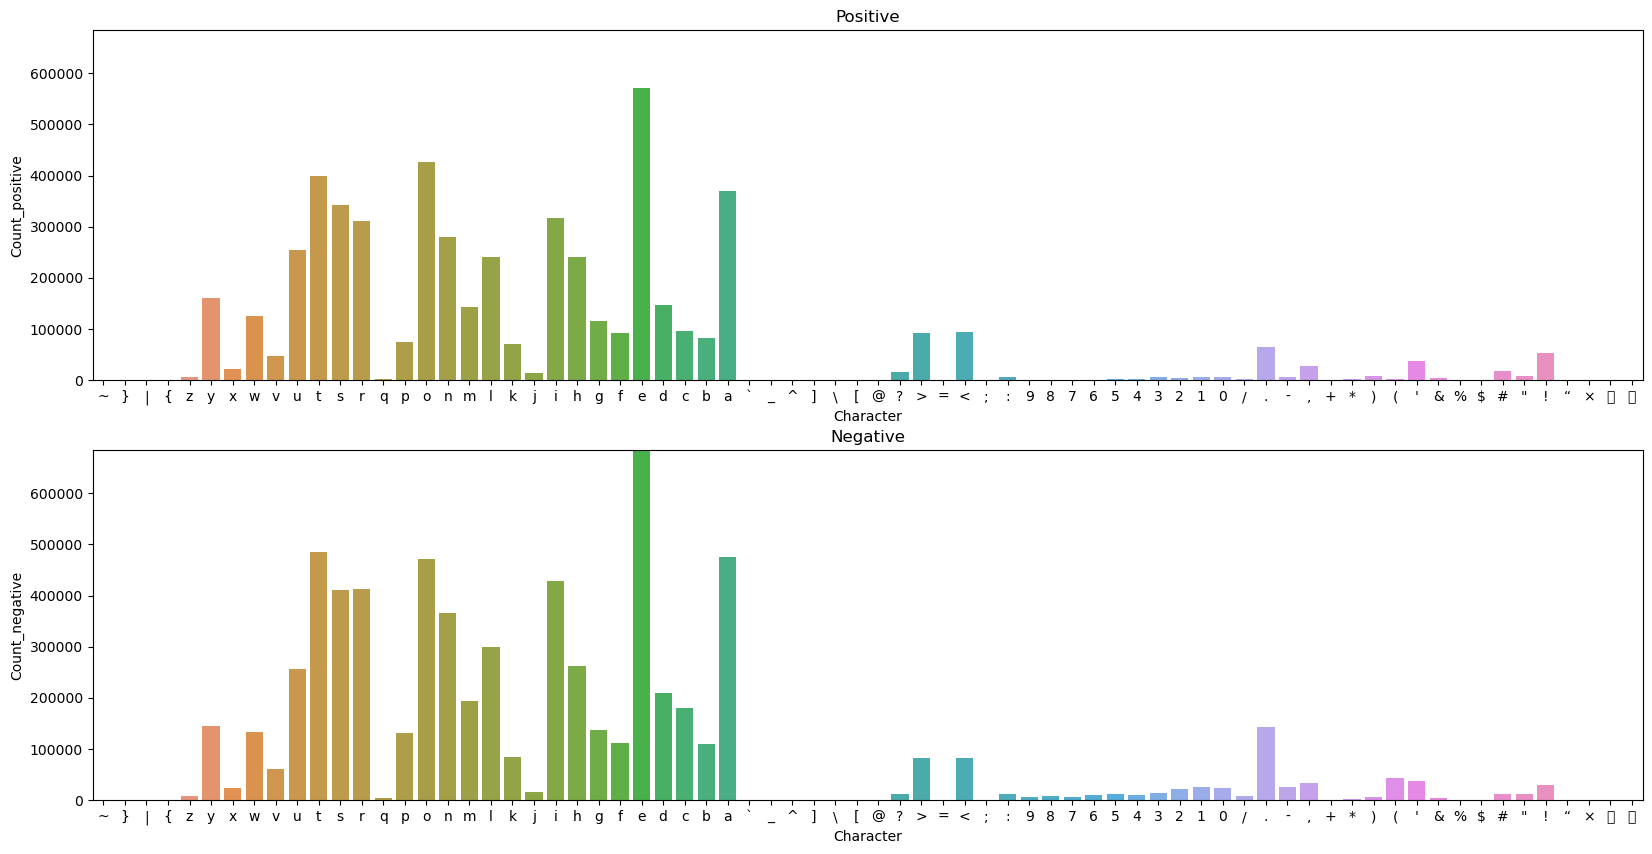

In [15]:
#Plot the characters for positive labels vs negative labels


# Set up a grid of plots
fig, axes = plt.subplots(nrows=2, figsize=(20, 10))

# Plot positive labels
sns.barplot(x='Character', y='Count_positive', data=merged_df, ax=axes[0]).set_title('Positive')

# Plot negative labels
sns.barplot(x='Character', y='Count_negative', data=merged_df, ax=axes[1]).set_title('Negative')

# Get the maximum y value among both dataframes
max_y = max(merged_df['Count_positive'].max(), merged_df['Count_negative'].max())

# Set the same y limit for both subplots
axes[0].set_ylim([0, max_y])
axes[1].set_ylim([0, max_y])

# Remove horizontal space between axes
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

In [16]:
positive_processed_df = positive_df.copy()
negative_processed_df = negative_df.copy()

positive_processed_df = positive_processed_df[~positive_processed_df['Character'].isin(list(string.ascii_letters + ' '))]
negative_processed_df = negative_processed_df[~negative_processed_df['Character'].isin(list(string.ascii_letters + ' '))]

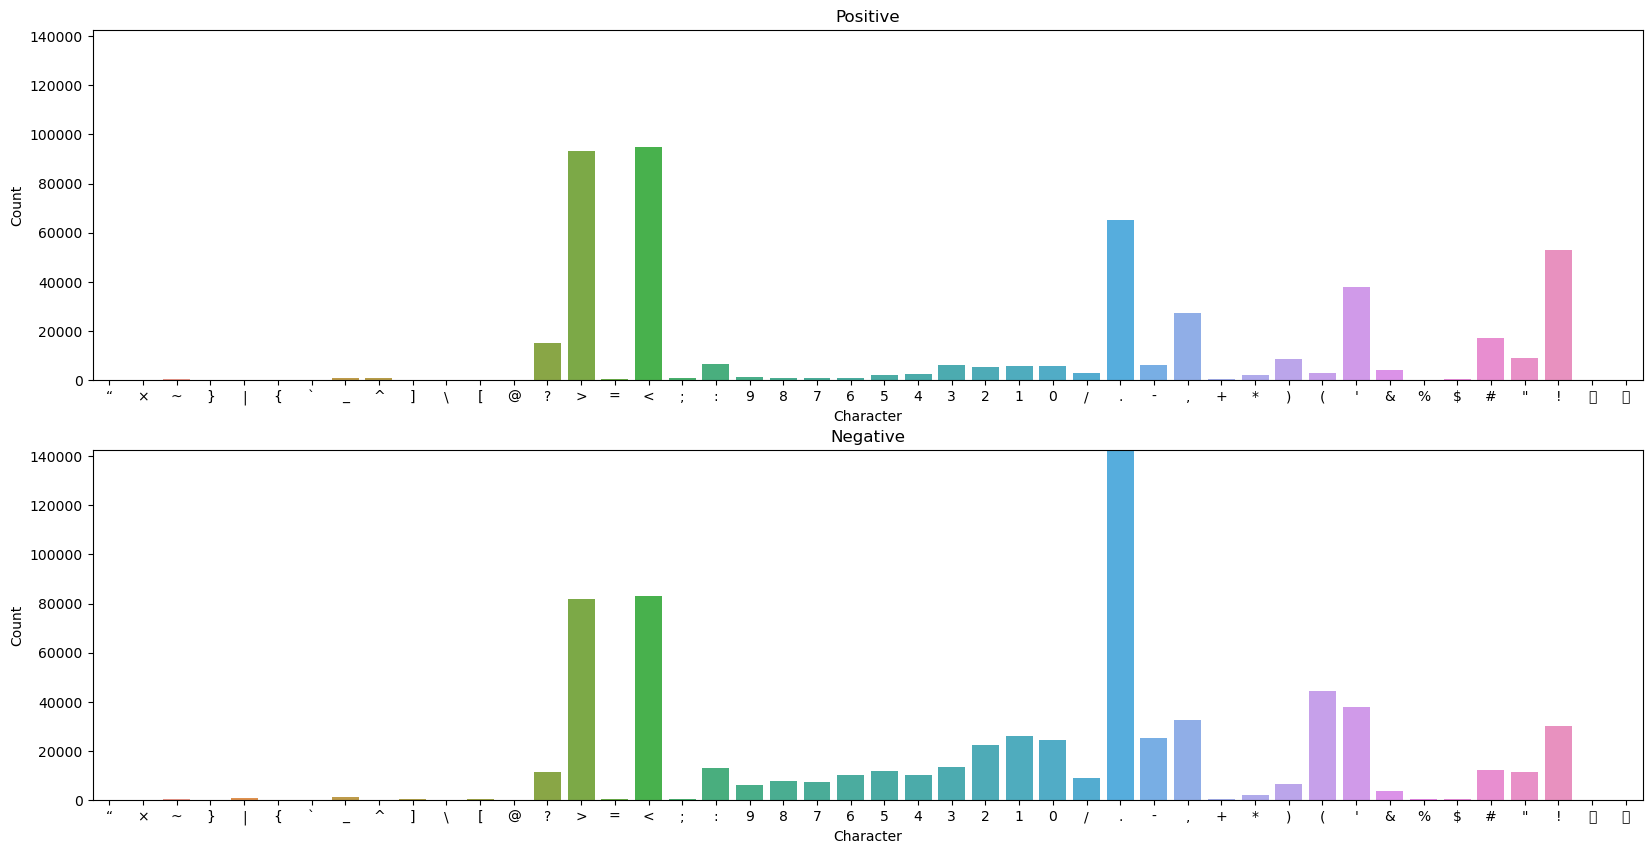

In [17]:
# Set up a grid of plots
fig, axes = plt.subplots(nrows=2, figsize=(20, 10))

# Plot positive labels
sns.barplot(x='Character', y='Count', data=positive_processed_df, ax=axes[0]).set_title('Positive')

# Plot negative labels
sns.barplot(x='Character', y='Count', data=negative_processed_df, ax=axes[1]).set_title('Negative')

# Get the maximum y value among both dataframes
max_y = max(positive_processed_df['Count'].max(), negative_processed_df['Count'].max())

# Set the same y limit for both subplots
axes[0].set_ylim([0, max_y])
axes[1].set_ylim([0, max_y])

# Remove horizontal space between axes
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

# Removing Duplicates

In [18]:
dataset_length = len(data_train)

methods = [
    'drop_duplicates',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

# number of duplicates
print("Number of duplicates:", dataset_length - len(dataset_train))


Executing: `drop_duplicates`
Executing: `drop_duplicates`
Executing: `drop_duplicates`
Number of duplicates: 18693


In [19]:
start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Accuracy: 0.796315702388175
Computation Time: 10.32128381729126


# Parenthesis Management


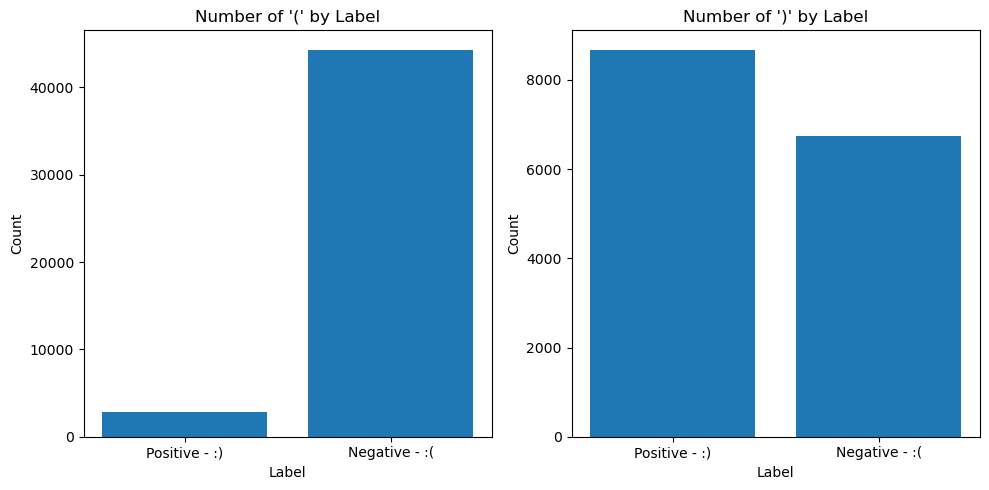

In [20]:
# Count the number of '(' and ')' for each label
labels = ['Positive - :)', 'Negative - :(']

count_pos_open = data_train[data_train['label'] == 1]['text'].str.count('\(').sum()
count_neg_open = data_train[data_train['label'] == 0]['text'].str.count('\(').sum()
count_pos_close = data_train[data_train['label'] == 1]['text'].str.count('\)').sum()
count_neg_close = data_train[data_train['label'] == 0]['text'].str.count('\)').sum()

counts_open = [count_pos_open, count_neg_open]
counts_close = [count_pos_close, count_neg_close]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot counts of '('
ax1.bar(labels, counts_open, label='(')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title("Number of '(' by Label")

# Plot counts of ')'
ax2.bar(labels, counts_close, label=')')

ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
ax2.set_title("Number of ')' by Label")

# Display the subplots
plt.tight_layout()

plt.show()

In [21]:
# Apply remove_tags to the 'text' column. We apply it 3 times in case there are nested parentheses
data_train_parenthesis_mng = data_train.copy()
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)

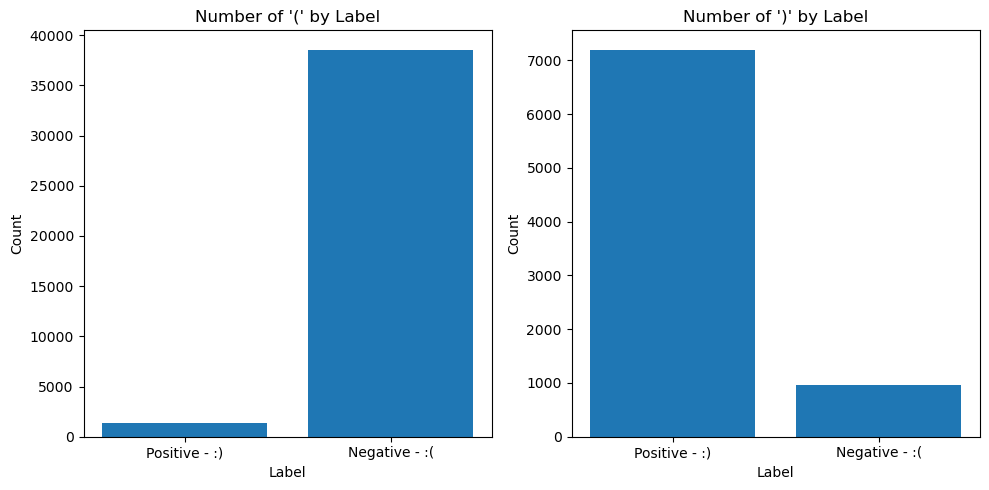

':((('

In [22]:
# Count the number of '(' and ')' for each label
labels = ['Positive - :)', 'Negative - :(']

count_pos_open = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 1]['text'].str.count('\(').sum()
count_neg_open = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 0]['text'].str.count('\(').sum()
count_pos_close = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 1]['text'].str.count('\)').sum()
count_neg_close = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 0]['text'].str.count('\)').sum()

counts_open = [count_pos_open, count_neg_open]
counts_close = [count_pos_close, count_neg_close]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot counts of '('
ax1.bar(labels, counts_open, label='(')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title("Number of '(' by Label")

# Plot counts of ')'
ax2.bar(labels, counts_close, label=')')

ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
ax2.set_title("Number of ')' by Label")

# Display the subplots
plt.tight_layout()

plt.show()

":)"
":((("

In [23]:
print(count_neg_open/(count_neg_close+count_neg_open))
print(count_pos_close/(count_pos_close+count_pos_open))
#expected : 0.9754548445051747
#expected : 0.8422653873157032

0.9754548445051747
0.8422653873157032


In [24]:
methods = [
    'remove_parentheses',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `remove_parentheses`
Executing: `remove_parentheses`
Executing: `drop_duplicates`
Accuracy: 0.796315702388175
Computation Time: 10.372653484344482


# Remove tags (\<user\> and \<url\>)

In [25]:
#Remove all the words in < > and the < > themselves
def remove_tags(text):
    """
    :type text: str
    :rtype: str
    """
    return re.sub("<[\w]*>", "", text)

In [26]:
remove_tags("<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15")

' i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15'

In [27]:
methods = [
    'remove_tag',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `remove_tag`
Executing: `strip`
Executing: `remove_tag`
Executing: `strip`
Executing: `drop_duplicates`
Accuracy: 0.79979035639413
Computation Time: 14.777869462966919


# Remove special characters 
except for `(,),-,!`

In [28]:
# Remove all the special characters except for parentheses ()
def remove_special_characters(text):
    """
    :type text: str
    :rtype: str
    """
    return re.sub('[^a-zA-Z0-9.!\-()]', ' ', text)

In [29]:
remove_special_characters("<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15")

' user  i dunno justin read my mention or not . only justin and god knows about that   but i hope you will follow me  believe 15'

In [30]:
methods = [
    'remove_selected_characters',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `remove_selected_characters`
Removing selected characters...
Executing: `remove_selected_characters`
Removing selected characters...
Executing: `drop_duplicates`
Accuracy: 0.7973300970873787
Computation Time: 10.758922576904297


# Word Segmentation

In [31]:
methods = [
    'word_segmentation',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `word_segmentation`


100%|██████████| 10000/10000 [00:10<00:00, 951.00it/s]


Executing: `word_segmentation`


100%|██████████| 200000/200000 [01:43<00:00, 1940.86it/s]


Executing: `drop_duplicates`
Accuracy: 0.7945451035547834
Computation Time: 10.42528772354126


# Hashtag to tag

In [33]:
methods = [
    'hashtag_to_tag',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `hashtag_to_tag`
Executing: `hashtag_to_tag`
Executing: `drop_duplicates`
Accuracy: 0.7960399316088467
Computation Time: 6.776350736618042


# Slang to Word

In [34]:
methods = [
    'slang_to_word',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `slang_to_word`


100%|██████████| 10000/10000 [00:00<00:00, 391529.97it/s]


Executing: `slang_to_word`


100%|██████████| 200000/200000 [00:00<00:00, 280401.84it/s]


Executing: `drop_duplicates`
Accuracy: 0.7958080529509101
Computation Time: 6.465338468551636


# Correct Spelling

In [35]:
methods = [
    'correct_spelling',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `correct_spelling`


100%|██████████| 10000/10000 [00:09<00:00, 1068.71it/s]


Executing: `correct_spelling`


100%|██████████| 200000/200000 [02:25<00:00, 1376.74it/s]


Executing: `drop_duplicates`
Accuracy: 0.7920083947753569
Computation Time: 5.358251571655273


# Numbers to Tag

In [36]:
methods = [
    'num_to_tag',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `num_to_tag`
Executing: `num_to_tag`
Executing: `drop_duplicates`
Accuracy: 0.7958990360505934
Computation Time: 9.546303272247314


# Lemmatize

In [37]:
methods = [
    'lemmatize',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `lemmatize`


100%|██████████| 10000/10000 [00:10<00:00, 971.20it/s]


Executing: `lemmatize`


100%|██████████| 200000/200000 [03:51<00:00, 862.75it/s] 


Executing: `drop_duplicates`
Accuracy: 0.795642581356867
Computation Time: 12.867077350616455


# Remove Stop Words

In [38]:
methods = [
    'remove_stopwords',
]
dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `remove_stopwords`


100%|██████████| 10000/10000 [00:00<00:00, 110914.94it/s]


Executing: `remove_stopwords`


100%|██████████| 200000/200000 [00:01<00:00, 120102.89it/s]


Executing: `drop_duplicates`
Accuracy: 0.7858902327641084
Computation Time: 12.164908647537231


# Combination of best methods


In [39]:
methods = [
    'drop_duplicates',
    'correct_spacing_indexing', 
    'remove_parentheses',
    'correct_spacing_indexing', 
    'word_segmentation',
    'correct_spacing_indexing',
    'remove_selected_characters',
    'correct_spacing_indexing',
    'hashtag_to_tag',
]

dataset_train, dataset_test = run_preprocessing(methods, full_data=False)

start_time = time.time()
test_dataset(dataset_train)
end_time = time.time()

computation_time = end_time - start_time
print("Computation Time:", computation_time)

Executing: `drop_duplicates`
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `remove_parentheses`
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `word_segmentation`


100%|██████████| 9215/9215 [00:11<00:00, 831.57it/s] 


Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `remove_selected_characters`
Removing selected characters...
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `hashtag_to_tag`
Executing: `drop_duplicates`
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `remove_parentheses`
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `word_segmentation`


100%|██████████| 181307/181307 [01:36<00:00, 1876.71it/s]


Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `remove_selected_characters`
Removing selected characters...
Executing: `correct_spacing_indexing`
Correcting spacing...
Executing: `hashtag_to_tag`
Executing: `drop_duplicates`
Accuracy: 0.7974620689655172
Computation Time: 11.514796733856201


# Google Flan-t5-Large

In [40]:
# pip install accelerate
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("C:/Users/rayji/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("C:/Users/rayji/flan-t5-large", device_map="auto")

input_text = "Rewrite this sentence by replacing slang words by normal words, removing spelling mistakes etc. : 'glad i dot have taks tomorrow ! ! #thankful #startho'"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


<pad>glad i dot have taks tomorrow!! #thankful #
